# Лабораторная работа №5. Построение нейронных сетей для Q-обучения с помощью PyTorch и Tensorflow

Горюнов Н.С., гр. 5140201/30301

## 1 Реализация на PyTorch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

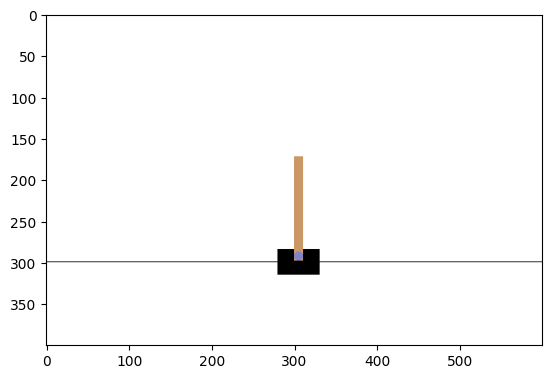

In [6]:
import gym
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

assert not torch.cuda.is_available()

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.network(x)

network = QNetwork(state_dim, n_actions)

def get_action(state, epsilon=0):
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    q_values = network(state_tensor).detach().numpy()[0]
    if np.random.rand() < epsilon:
        # Выполняем случайное действие
        return int(np.random.choice(n_actions))
    # Действие с наибольшим Q(s,a)
    return int(np.argmax(q_values))

s = env.reset()
assert network(torch.tensor(np.array([s] * 5), dtype=torch.float32)).shape == (5, n_actions), "пожалуйста, убедитесь, что ваша модель отображает состояние s -> [Q(s,a0),..., Q(s, a_last)]"

assert isinstance(list(network.modules())[-1], nn.Linear),"пожалуйста, убедитесь, что вы предсказываете q-значения без нелинейности"

In [3]:
# Тест эпсилон-жадных исследований
assert isinstance(get_action(s), int), "верните только одно действие (integer)"

for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


In [4]:
# Функция для генерации эпизодов с обучением агента
def generate_session(env, t_max=1000, epsilon=0, train=False):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

       # Создадим тензоры  для  кортежа и специального индикатора окончания игры (is_done = True)
        states_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        actions_tensor = torch.tensor([a], dtype=torch.int64)
        rewards_tensor = torch.tensor([r], dtype=torch.float32)
        next_states_tensor = torch.tensor(next_s, dtype=torch.float32).unsqueeze(0)
        is_done_tensor = torch.tensor([done], dtype=torch.bool)

        # Задание q-значений для всех действий в текущем состоянии
        predicted_qvalues = network(states_tensor)
        #выборка q-значений для выбранных действий
        predicted_qvalues_for_actions = torch.sum(predicted_qvalues * F.one_hot(actions_tensor, num_classes=n_actions), dim=1)

        # Вычисление Q-значений для следующих состояний
        predicted_next_qvalues = network(next_states_tensor)
        next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]

        # Целевые Q-значения
        target_qvalues_for_actions = rewards_tensor + gamma * next_state_values
        target_qvalues_for_actions = torch.where(is_done_tensor, rewards_tensor, target_qvalues_for_actions)# выбор только награды для конечного состояния

        # Потери
        loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

        # Оптимизация
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_reward += r
        s = next_s
        if done:
            break

        # Тесты
        assert predicted_next_qvalues.data.dim() == 2, "убедитесь, что вы предсказали значения q для всех действий в следующем состоянии"
        assert next_state_values.data.dim() == 1, "убедитесь, что вы вычислили V (s') как максимум только по оси действий, а не по всем осям"
        assert target_qvalues_for_actions.data.dim() == 1, "целевые Q-значения должны быть вектором"

    return total_reward

In [7]:
# Оптимизатор и обучение
gamma = 0.99
optimizer = optim.Adam(network.parameters(), lr=1e-4)

epsilon = 0.5
for i in range(1000):
    start_time = time.time()  # Замер времени начала эпохи
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    epoch_time = time.time() - start_time  # Вычисление времени выполнения эпохи
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}\ttime = {:.2f}s".format(i, np.mean(session_rewards), epsilon, epoch_time))
    epsilon *= 0.99
    assert epsilon >= 1e-4, " Убедитесь, что эпсилон всегда отличен от нуля во время обучения "

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


epoch #0	mean reward = 13.810	epsilon = 0.500	time = 4.98s
epoch #1	mean reward = 14.450	epsilon = 0.495	time = 3.24s
epoch #2	mean reward = 14.550	epsilon = 0.490	time = 3.28s
epoch #3	mean reward = 12.900	epsilon = 0.485	time = 3.56s
epoch #4	mean reward = 13.250	epsilon = 0.480	time = 3.53s
epoch #5	mean reward = 14.990	epsilon = 0.475	time = 3.67s
epoch #6	mean reward = 15.860	epsilon = 0.471	time = 3.42s
epoch #7	mean reward = 16.200	epsilon = 0.466	time = 4.65s
epoch #8	mean reward = 15.980	epsilon = 0.461	time = 3.84s
epoch #9	mean reward = 18.810	epsilon = 0.457	time = 4.11s
epoch #10	mean reward = 32.820	epsilon = 0.452	time = 8.25s
epoch #11	mean reward = 31.140	epsilon = 0.448	time = 9.02s
epoch #12	mean reward = 41.880	epsilon = 0.443	time = 10.84s
epoch #13	mean reward = 44.080	epsilon = 0.439	time = 10.38s
epoch #14	mean reward = 46.030	epsilon = 0.434	time = 11.11s
epoch #15	mean reward = 55.600	epsilon = 0.430	time = 13.41s
epoch #16	mean reward = 60.510	epsilon = 0.426

## 2 Реализация на Tensorflow

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

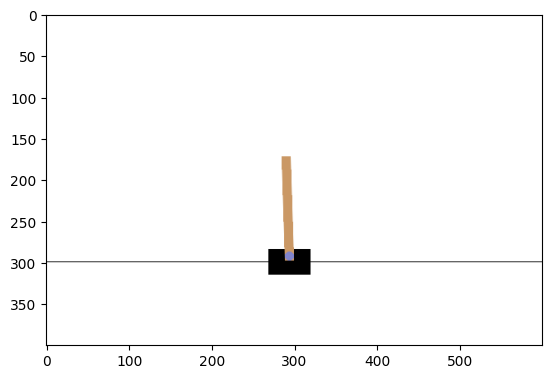

In [14]:
import gym
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

env = gym.make("CartPole-v1").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

In [11]:
class QNetwork(tf.keras.Model):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.network = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=state_dim),
            layers.Dense(128, activation='relu'),
            layers.Dense(n_actions)
        ])

    def call(self, x):
        return self.network(x)

network = QNetwork(state_dim, n_actions)

def get_action(state, epsilon=0):
    state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)[None, :]
    q_values = network(state_tensor).numpy()[0]
    if np.random.rand() < epsilon:
        # Выполняем случайное действие
        return int(np.random.choice(n_actions))
    # Действие с наибольшим Q(s,a)
    return int(np.argmax(q_values))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
s = env.reset()
assert network(tf.convert_to_tensor(np.array([s] * 5), dtype=tf.float32)).shape == (5, n_actions), "пожалуйста, убедитесь, что ваша модель отображает состояние s -> [Q(s,a0),..., Q(s, a_last)]"

# Проверка эпсилон-жадных исследований
assert isinstance(get_action(s), int), "верните только одно действие (integer)"

for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


In [13]:
# Функция для генерации эпизодов с обучением агента
def generate_session(env, t_max=1000, epsilon=0, train=False):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        # Создадим тензоры для кортежа и специального индикатора окончания игры (is_done = True)
        states_tensor = tf.convert_to_tensor(s, dtype=tf.float32)[None, :]
        actions_tensor = tf.convert_to_tensor([a], dtype=tf.int64)
        rewards_tensor = tf.convert_to_tensor([r], dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_s, dtype=tf.float32)[None, :]
        is_done_tensor = tf.convert_to_tensor([done], dtype=tf.bool)

        if train:
            with tf.GradientTape() as tape:
                # Задание q-значений для всех действий в текущем состоянии
                predicted_qvalues = network(states_tensor)
                # Выборка q-значений для выбранных действий
                predicted_qvalues_for_actions = tf.reduce_sum(
                    predicted_qvalues * tf.one_hot(actions_tensor, n_actions), axis=1
                )

                # Вычисление Q-значений для следующих состояний
                predicted_next_qvalues = network(next_states_tensor)
                next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

                # Целевые Q-значения
                target_qvalues_for_actions = rewards_tensor + gamma * next_state_values
                target_qvalues_for_actions = tf.where(
                    is_done_tensor, rewards_tensor, target_qvalues_for_actions
                )

                # Потери
                loss = tf.reduce_mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

            # Оптимизация
            grads = tape.gradient(loss, network.trainable_variables)
            optimizer.apply_gradients(zip(grads, network.trainable_variables))

        total_reward += r
        s = next_s
        if done:
            break

        # Тесты
        assert predicted_qvalues.shape[1] == n_actions, \
            "Убедитесь, что вы предсказали значения Q для всех действий в следующем состоянии"
        assert next_state_values.shape[0] == 1, \
            "Убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert target_qvalues_for_actions.shape[0] == 1, \
            "Целевые Q-значения должны быть вектором"

    return total_reward

In [ ]:
# Оптимизатор и обучение
gamma = 0.99
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

epsilon = 0.5
for i in range(1000):
    start_time = time.time()  # Замер времени начала эпохи
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    epoch_time = time.time() - start_time  # Вычисление времени выполнения эпохи
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}\ttime = {:.2f}s".format(i, np.mean(session_rewards), epsilon, epoch_time))
    epsilon *= 0.99
    assert epsilon >= 1e-4, " Убедитесь, что эпсилон всегда отличен от нуля во время обучения "

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


epoch #0	mean reward = 24.940	epsilon = 0.500	time = 138.43s
epoch #1	mean reward = 23.380	epsilon = 0.495	time = 134.45s
epoch #2	mean reward = 20.020	epsilon = 0.490	time = 115.30s
epoch #3	mean reward = 23.040	epsilon = 0.485	time = 129.99s
epoch #4	mean reward = 24.870	epsilon = 0.480	time = 140.32s
epoch #5	mean reward = 29.520	epsilon = 0.475	time = 163.14s
epoch #6	mean reward = 37.260	epsilon = 0.471	time = 208.53s
epoch #7	mean reward = 33.330	epsilon = 0.466	time = 198.03s
epoch #8	mean reward = 29.790	epsilon = 0.461	time = 174.43s
epoch #9	mean reward = 32.210	epsilon = 0.457	time = 187.00s
epoch #10	mean reward = 40.190	epsilon = 0.452	time = 233.34s
epoch #11	mean reward = 35.460	epsilon = 0.448	time = 207.84s
epoch #12	mean reward = 35.680	epsilon = 0.443	time = 216.89s
epoch #13	mean reward = 42.390	epsilon = 0.439	time = 239.67s
epoch #14	mean reward = 50.070	epsilon = 0.434	time = 282.19s
epoch #15	mean reward = 47.280	epsilon = 0.430	time = 264.26s
epoch #16	mean rew